In [ ]:
!pip install cairosvg
!pip install opencv-python
!pip install easyocr
!pip install torch torchvision
!pip install transformers
!pip install Pillow
!pip install matplotlib
!pip install scikit-learn
!pip install numpy

🔎 Fetching icons from Eraser docs...


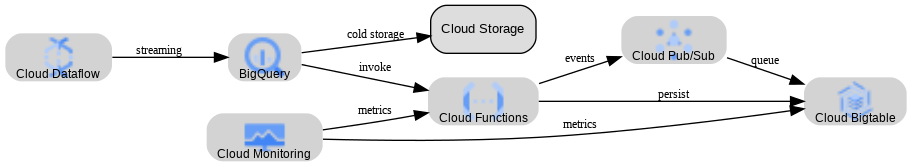

In [ ]:
import json
from graphviz import Digraph
from IPython.display import Image, display
import requests
import cairosvg
import os
from bs4 import BeautifulSoup

# ----------------------------
# Step 1: Scrape icon names + URLs from Eraser docs
# ----------------------------
base_url = "https://docs.eraser.io"
icons_url = f"{base_url}/docs/icons"

print("🔎 Fetching icons from Eraser docs...")
res = requests.get(icons_url)
soup = BeautifulSoup(res.text, "html.parser")

icon_dir = "/content/icons"
os.makedirs(icon_dir, exist_ok=True)

# for downloading icons
# Dictionary: { "gcp-bigquery": "/content/icons/gcp-bigquery.png", ... }


icons = {}

for td in soup.find_all("td"):
    img = td.find("img")
    label = td.get_text(strip=True)  # e.g. aws-athena, gcp-bigquery
    if img and label:
        # svg_url = base_url + img["src"]
        from urllib.parse import urljoin

        src = img["src"]
        if src.startswith("//"):
            svg_url = "https:" + src   # protocol-relative → add https:
        else:
            svg_url = urljoin(base_url, src)  # handles relative paths safely

        svg_path = os.path.join(icon_dir, f"{label}.svg")
        png_path = os.path.join(icon_dir, f"{label}.png")

        # Download SVG if not cached
        if not os.path.exists(svg_path):
            r = requests.get(svg_url)
            with open(svg_path, "wb") as f:
                f.write(r.content)

        # Convert SVG -> PNG if not cached
        if not os.path.exists(png_path):
            cairosvg.svg2png(url=svg_path, write_to=png_path)

        icons[label.lower()] = png_path

print(f"✅ Scraped and cached {len(icons)} icons")

# ----------------------------
# Step 2: Load your architecture JSON
# ----------------------------
with open("/content/prompt_0002.json", "r") as f:
    data = json.load(f)

if "messages" in data:
    assistant_content = data["messages"][-1]["content"]
    diagram = json.loads(assistant_content)
else:
    diagram = data

# ----------------------------
# Step 3: Map entities → icons
# ----------------------------
def get_icon(ent):
    service = ent.get("service", "").lower().replace("_", "-")
    cloud = ent.get("cloud_provider", "").lower()
    key = f"{cloud}-{service}"   # e.g. gcp-bigquery
    return icons.get(key)

# ----------------------------
# Step 4: Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", bgcolor="white")
dot.attr("node", shape="rect", style="rounded,filled", fontname="Helvetica", fontsize="10")

# Add nodes
for ent in diagram["entities"]:
    node_id = ent["id"]
    label = ent.get("label", node_id)

    icon_path = get_icon(ent)

    if icon_path:
        dot.node(
            node_id,
            label=label,
            image=icon_path,
            shape="none",
            labelloc="b",
            fontsize="9",
            fixedsize="false",
            imagescale="true"
        )
    else:
        dot.node(
            node_id,
            label=label,
            fillcolor="#DDDDDD",
            color="black"
        )

# Add edges
for rel in diagram["relationships"]:
    style = rel.get("style", {})
    attrs = {}
    if style.get("dash") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], label=rel["label"], fontsize="9")

# Render & display
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))


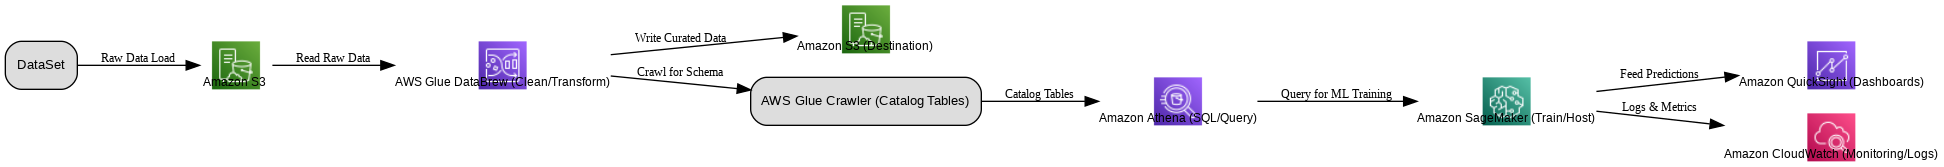

In [ ]:
with open("/content/prompt_0002 - Copy.json", "r") as f:
    data = json.load(f)

if "messages" in data:
    assistant_content = data["messages"][-1]["content"]
    diagram = json.loads(assistant_content)
else:
    diagram = data



def get_icon(ent):
    service = ent.get("service", "").lower().replace("_", "-")
    cloud = ent.get("cloud_provider", "").lower()
    key = f"{cloud}-{service}"

    # # 🔹 Special-case mapping for users/clients
    if service in ["user", "users", "client", "end-user", "customer"]:
        return icons.get("generic-user")  # <-- put your user/person silhouette key here

    # Exact match first
    if key in icons:
        return icons[key]

    # Fuzzy match within cloud provider
    for k, path in icons.items():
        if cloud in k and service in k:
            return path

    # Fuzzy match fallback (no cloud restriction)
    for k, path in icons.items():
        if service in k:
            return path

    return None


# ----------------------------
# Step 4: Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", bgcolor="white")

# Default node style (only applies to text-only nodes)
dot.attr("node", shape="rect", style="rounded,filled", fontname="Helvetica", fontsize="10", fillcolor="#DDDDDD")

# Add nodes
for ent in diagram["entities"]:
    node_id = ent["id"]
    label = ent.get("label", node_id)
    icon_path = get_icon(ent)

    if icon_path:
        # Icon node with NO box
        dot.node(
            node_id,
            label=label,         # "" if you want icon only
            image=icon_path,
            shape="none",
            labelloc="b",
            fontsize="9",
            fixedsize="false",
            imagescale="true",
            margin="0",
            style=""             # <-- clears the rounded/filled box style
        )
    else:
        # Fallback: normal rectangle node
        dot.node(
            node_id,
            label=label,
            shape="rect",
            style="rounded,filled",
            fillcolor="#DDDDDD",
            color="black"
        )

# Add edges
for rel in diagram["relationships"]:
    style = rel.get("style", {})
    attrs = {}
    if style.get("dash") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], label=rel["label"], fontsize="9")

# Render & display
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))


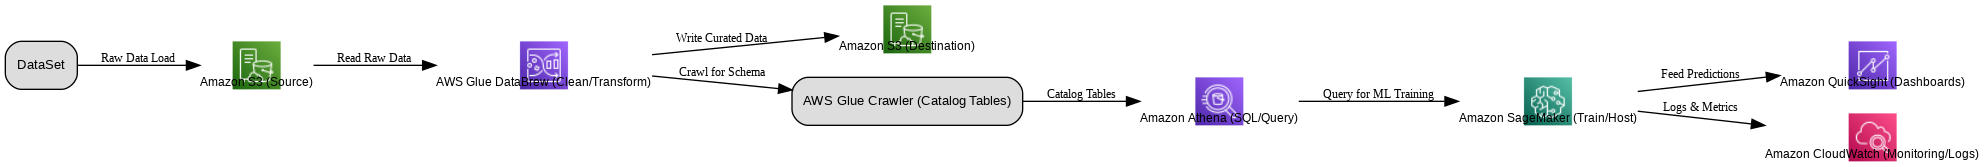

In [ ]:
with open("/content/prompt_0002 - Copy.json", "r") as f:
    data = json.load(f)

if "messages" in data:
    assistant_content = data["messages"][-1]["content"]
    diagram = json.loads(assistant_content)
else:
    diagram = data

# ----------------------------
# Step 3: Map entities → icons
# ----------------------------
# def get_icon(ent):
#     service = ent.get("service", "").lower().replace("_", "-")
#     cloud = ent.get("cloud_provider", "").lower()
#     key = f"{cloud}-{service}"   # e.g. gcp-bigquery
#     return icons.get(key)


# def get_icon(ent):
#     service = ent.get("service", "").lower().replace("_", "-")
#     cloud = ent.get("cloud_provider", "").lower()
#     key = f"{cloud}-{service}"   # e.g., aws-s3

#     # Direct exact match first
#     if key in icons:
#         return icons[key]

#     # Fuzzy match: if service name contains part of an icon key
#     for k, path in icons.items():
#         if service in k or k.endswith(service) or service in k.split("-"):
#             if cloud in k:   # make sure cloud matches too
#                 return path

#     # Extra fallback: check just by service name
#     for k, path in icons.items():
#         if service in k:
#             return path

#     return None   # no match found


def get_icon(ent):
    service = ent.get("service", "").lower().replace("_", "-")
    cloud = ent.get("cloud_provider", "").lower()
    key = f"{cloud}-{service}"

    # 🔹 Special-case mapping for users/clients
    if service in ["user", "users", "client", "end-user", "customer"]:
        return icons.get("generic-user")  # <-- put your user/person silhouette key here

    # Exact match first
    if key in icons:
        return icons[key]

    # Fuzzy match within cloud provider
    for k, path in icons.items():
        if cloud in k and service in k:
            return path

    # Fuzzy match fallback (no cloud restriction)
    for k, path in icons.items():
        if service in k:
            return path

    return None


# ----------------------------
# Step 4: Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", bgcolor="white")

# Default node style (only applies to text-only nodes)
dot.attr("node", shape="rect", style="rounded,filled", fontname="Helvetica", fontsize="10", fillcolor="#DDDDDD")

# Add nodes
for ent in diagram["entities"]:
    node_id = ent["id"]
    label = ent.get("label", node_id)
    icon_path = get_icon(ent)

    if icon_path:
        # Icon node with NO box
        dot.node(
            node_id,
            label=label,         # "" if you want icon only
            image=icon_path,
            shape="none",
            labelloc="b",
            fontsize="9",
            fixedsize="false",
            imagescale="true",
            margin="0",
            style=""             # <-- clears the rounded/filled box style
        )
    else:
        # Fallback: normal rectangle node
        dot.node(
            node_id,
            label=label,
            shape="rect",
            style="rounded,filled",
            fillcolor="#DDDDDD",
            color="black"
        )

# Add edges
for rel in diagram["relationships"]:
    style = rel.get("style", {})
    attrs = {}
    if style.get("dash") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], label=rel["label"], fontsize="9")

# Render & display
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))


Scraping icon URLs from Eraser.io...
Successfully scraped 0 icon URLs.

Rendering diagram...


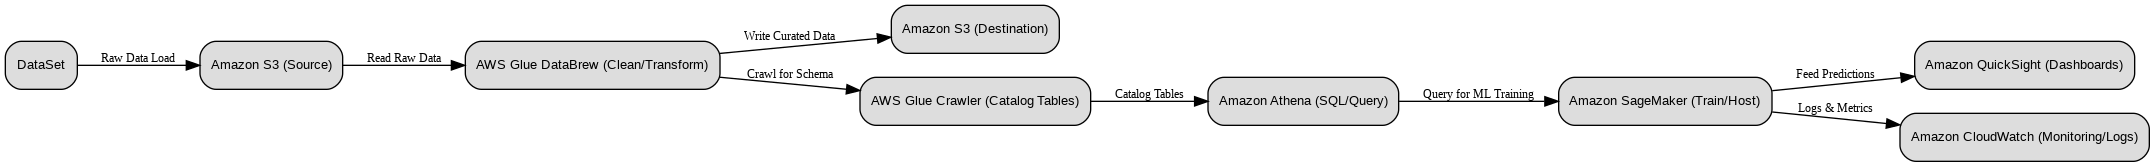

Diagram generation complete.


In [13]:
import json
from graphviz import Digraph
from IPython.display import Image, display
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# ----------------------------
# Step 1: Scrape and Cache Icons
# ----------------------------

def scrape_eraser_icons(url="https://docs.eraser.io/docs/icons"):
    """
    Scrapes the Eraser.io icon documentation page to build a map of
    icon keywords to their full image URLs.
    """
    print("Scraping icon URLs from Eraser.io...")
    icon_map = {}
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        # This selector is specific to the page's current HTML structure
        # and may break if the website is updated.
        icon_blocks = soup.find_all('div', class_='flex items-center gap-4')

        for block in icon_blocks:
            code_tag = block.find('code')
            img_tag = block.find('img')

            if code_tag and img_tag and img_tag.has_attr('src'):
                icon_name = code_tag.get_text(strip=True)
                # The src can be a relative path, so we join it with the base URL
                icon_url = urljoin(url, img_tag['src'])
                icon_map[icon_name] = icon_url

        print(f"Successfully scraped {len(icon_map)} icon URLs.")
        return icon_map
    except requests.exceptions.RequestException as e:
        print(f"Error: Could not fetch the icon page. {e}")
        return {}

def download_and_cache_icon(icon_url, service_name, cache_folder="icon_cache"):
    """
    Downloads an icon from a URL to a local cache folder if it doesn't
    already exist. Returns the local path to the icon.
    """
    if not icon_url:
        return None

    if not os.path.exists(cache_folder):
        os.makedirs(cache_folder)

    # Create a simple local filename from the service name
    file_extension = os.path.splitext(urlparse(icon_url).path)[1]
    if not file_extension:
        file_extension = ".svg" # Default to svg if no extension found
    local_path = os.path.join(cache_folder, f"{service_name.lower()}{file_extension}")

    # Download only if the file doesn't exist in the cache
    if not os.path.exists(local_path):
        try:
            response = requests.get(icon_url, timeout=10)
            response.raise_for_status()
            with open(local_path, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded icon for: {service_name}")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {icon_url}: {e}")
            return None

    return local_path

# ----------------------------
# Step 2: Load Data and Scrape Icons
# ----------------------------
# Scrape the icon URLs once at the beginning
icons = scrape_eraser_icons()

# Load JSON file
with open("/content/prompt_0002 - Copy.json", "r") as f:
    data = json.load(f)

if "messages" in data:
    assistant_content = data["messages"][-1]["content"]
    diagram = json.loads(assistant_content)
else:
    diagram = data

# ----------------------------
# Step 3: Map entities → icons (Your function, slightly adapted)
# ----------------------------
def get_icon_path(ent):
    service = ent.get("service", "").lower().replace("_", "-")
    cloud = ent.get("cloud_provider", "").lower()
    key = f"{cloud}-{service}"

    # Special-case mapping for users/clients
    if service in ["user", "users", "client", "end-user", "customer"]:
        icon_url = icons.get("generic-user")
        return download_and_cache_icon(icon_url, "generic-user")

    # Exact match first (e.g., 'gcp-bigquery')
    icon_url = icons.get(key)
    if icon_url:
        return download_and_cache_icon(icon_url, key)

    # Fuzzy match within cloud provider
    for k, url in icons.items():
        if cloud in k and service in k:
            return download_and_cache_icon(url, k)

    # Fuzzy match fallback (no cloud restriction)
    for k, url in icons.items():
        if service in k:
            return download_and_cache_icon(url, k)

    return None


# ----------------------------
# Step 4: Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", bgcolor="white")

# Default node style (only applies to text-only nodes)
dot.attr("node", shape="rect", style="rounded,filled", fontname="Helvetica", fontsize="10", fillcolor="#DDDDDD")

# Add nodes
for ent in diagram["entities"]:
    node_id = ent["id"]
    label = ent.get("label", node_id)
    icon_path = get_icon_path(ent)

    if icon_path:
        # Icon node with NO box
        dot.node(
            node_id,
            label=label,
            image=icon_path,
            shape="none",
            labelloc="b",
            fontsize="9",
            fixedsize="false",
            imagescale="true",
            margin="0",
            style="" # <-- clears the rounded/filled box style
        )
    else:
        # Fallback: normal rectangle node
        print(f"Warning: No icon found for service '{ent.get('service', 'N/A')}'. Using a default box.")
        dot.node(
            node_id,
            label=label,
            shape="rect",
            style="rounded,filled",
            fillcolor="#DDDDDD",
            color="black"
        )

# Add edges
for rel in diagram["relationships"]:
    style = rel.get("style", {})
    attrs = {}
    if style.get("dash") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], label=rel.get("label", ""), fontsize="9", **attrs)

# Render & display
print("\nRendering diagram...")
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))
print("Diagram generation complete.")

⚠️ Could not fetch icon for dataset: 404 Client Error: Not Found for url: https://storage.googleapis.com/eraser-public-assets/canvas-icons/generic-database.svg
⚠️ No icon for dataset, using default box
Downloaded and converted: s3 → icon_cache/aws-simple-storage-service.png
Downloaded and converted: glue-databrew → icon_cache/aws-glue-databrew.png
⚠️ Could not fetch icon for glue-crawler: 404 Client Error: Not Found for url: https://storage.googleapis.com/eraser-public-assets/canvas-icons/aws-glue-data-catalog.svg
⚠️ No icon for glue-crawler, using default box
Downloaded and converted: athena → icon_cache/aws-athena.png
Downloaded and converted: sagemaker → icon_cache/aws-sagemaker.png
Downloaded and converted: quicksight → icon_cache/aws-quicksight.png
Downloaded and converted: cloudwatch → icon_cache/aws-cloudwatch.png

Rendering diagram...


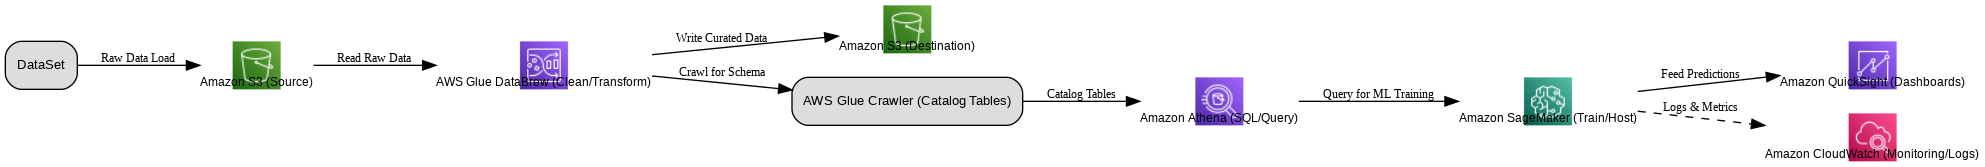

Diagram complete ✅
🗑️ Cleared old icon cache


In [22]:
import json
from graphviz import Digraph
from IPython.display import Image, display
import os
import requests
from cairosvg import svg2png  # <-- for converting SVG to PNG

# ----------------------------
# Step 1: Service -> Icon filename map
# ----------------------------
icon_filename_map = {
    "s3": "aws-simple-storage-service.svg",
    "glue-databrew": "aws-glue-databrew.svg",
    "glue-crawler": "aws-glue-data-catalog.svg",
    "athena": "aws-athena.svg",
    "sagemaker": "aws-sagemaker.svg",
    "quicksight": "aws-quicksight.svg",
    "cloudwatch": "aws-cloudwatch.svg",
    "dataset": "generic-database.svg"  # this one is custom/fallback
}

BASE_URL = "https://storage.googleapis.com/eraser-public-assets/canvas-icons/"

def download_and_cache_icon(service, cache_folder="icon_cache"):
    if not os.path.exists(cache_folder):
        os.makedirs(cache_folder)

    filename = icon_filename_map.get(service)
    if not filename:
        return None

    url = BASE_URL + filename
    svg_path = os.path.join(cache_folder, filename)
    png_path = svg_path.replace(".svg", ".png")

    if not os.path.exists(png_path):  # download & convert if missing
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            with open(svg_path, "wb") as f:
                f.write(response.content)
            # Convert to PNG
            svg2png(url=url, write_to=png_path)
            print(f"Downloaded and converted: {service} → {png_path}")
        except Exception as e:
            print(f"⚠️ Could not fetch icon for {service}: {e}")
            return None
    return png_path

# ----------------------------
# Step 2: Load JSON file
# ----------------------------
with open("/content/prompt_0002 - Copy.json", "r") as f:
    data = json.load(f)

diagram = data.get("messages", [{}])[-1].get("content")
diagram = json.loads(diagram) if diagram else data

# ----------------------------
# Step 3: Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", bgcolor="white")

dot.attr("node", shape="rect", style="rounded,filled", fontname="Helvetica", fontsize="10", fillcolor="#DDDDDD")

for ent in diagram["entities"]:
    node_id = ent["id"]
    label = ent.get("label", node_id)
    service = ent.get("service", "").lower()

    icon_path = download_and_cache_icon(service)

    if icon_path and os.path.exists(icon_path):
        dot.node(
            node_id,
            label=label,
            image=icon_path,
            shape="none",
            labelloc="b",
            fontsize="9",
            fixedsize="false",
            imagescale="true",
            margin="0",
            style=""
        )
    else:
        print(f"⚠️ No icon for {service}, using default box")
        dot.node(node_id, label=label, shape="rect", style="rounded,filled", fillcolor="#DDDDDD")

# Add edges
for rel in diagram["relationships"]:
    style = rel.get("style", {})
    attrs = {}
    if style.get("lineType") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], label=rel.get("label", ""), fontsize="9", **attrs)

# Render & display
print("\nRendering diagram...")
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))
print("Diagram complete ✅")

import shutil
import os

CACHE_FOLDER = "icon_cache"

# ----------------------------
# Step 0: Clear cache if it exists
# ----------------------------
if os.path.exists(CACHE_FOLDER):
    shutil.rmtree(CACHE_FOLDER)   # delete entire folder
    print("🗑️ Cleared old icon cache")


⚠️ Could not fetch icon for generic-user: 404 Client Error: Not Found for url: https://storage.googleapis.com/eraser-public-assets/canvas-icons/generic-user.svg
⚠️ No icon for generic-user, using default box
Downloaded and converted: amplify → icon_cache/aws-amplify.png
Downloaded and converted: cognito → icon_cache/aws-cognito.png
Downloaded and converted: api-gateway → icon_cache/aws-api-gateway.png
Downloaded and converted: vpc → icon_cache/aws-vpc.png
Downloaded and converted: lambda → icon_cache/aws-lambda.png
Downloaded and converted: sagemaker → icon_cache/aws-sagemaker.png
Downloaded and converted: opensearch-service → icon_cache/aws-opensearch-service.png
Downloaded and converted: fargate → icon_cache/aws-fargate.png

Rendering diagram...


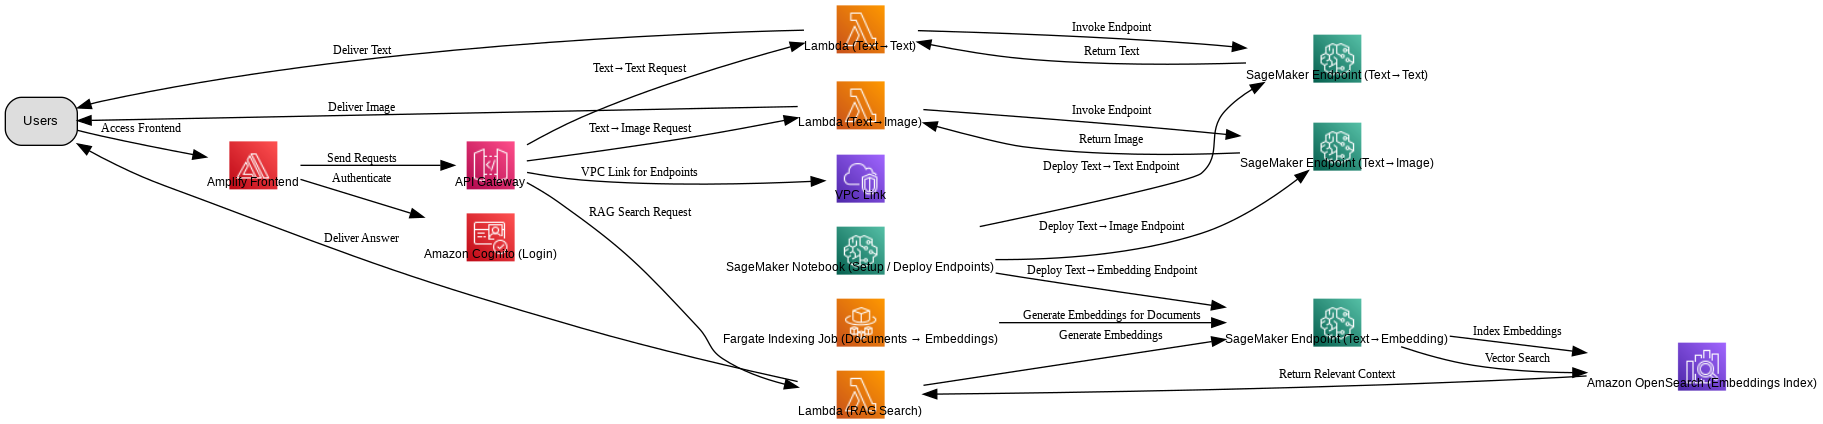

Diagram complete ✅
🗑️ Cleared old icon cache


In [28]:
import json
from graphviz import Digraph
from IPython.display import Image, display
import os
import requests
from cairosvg import svg2png  # <-- for converting SVG to PNG

# ----------------------------
# Step 1: Service -> Icon filename map
# ----------------------------

icon_filename_map = {
    "generic-user": "generic-user.svg",  # <-- fallback, you can store locally
    "amplify": "aws-amplify.svg",
    "cognito": "aws-cognito.svg",
    "api-gateway": "aws-api-gateway.svg",
    "vpc": "aws-vpc.svg",
    "lambda": "aws-lambda.svg",
    "sagemaker": "aws-sagemaker.svg",
    "opensearch-service": "aws-opensearch-service.svg",
    "fargate": "aws-fargate.svg"

}

BASE_URL = "https://storage.googleapis.com/eraser-public-assets/canvas-icons/"

def download_and_cache_icon(service, cache_folder="icon_cache"):
    if not os.path.exists(cache_folder):
        os.makedirs(cache_folder)

    filename = icon_filename_map.get(service)
    if not filename:
        return None

    url = BASE_URL + filename
    svg_path = os.path.join(cache_folder, filename)
    png_path = svg_path.replace(".svg", ".png")

    if not os.path.exists(png_path):  # download & convert if missing
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            with open(svg_path, "wb") as f:
                f.write(response.content)
            # Convert to PNG
            svg2png(url=url, write_to=png_path)
            print(f"Downloaded and converted: {service} → {png_path}")
        except Exception as e:
            print(f"⚠️ Could not fetch icon for {service}: {e}")
            return None
    return png_path

# ----------------------------
# Step 2: Load JSON file
# ----------------------------
with open("/content/prompt_0001.json", "r") as f:
    data = json.load(f)

diagram = data.get("messages", [{}])[-1].get("content")
diagram = json.loads(diagram) if diagram else data

# ----------------------------
# Step 3: Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", bgcolor="white")

dot.attr("node", shape="rect", style="rounded,filled", fontname="Helvetica", fontsize="10", fillcolor="#DDDDDD")

for ent in diagram["entities"]:
    node_id = ent["id"]
    label = ent.get("label", node_id)
    service = ent.get("service", "").lower()

    icon_path = download_and_cache_icon(service)

    if icon_path and os.path.exists(icon_path):
        dot.node(
            node_id,
            label=label,
            image=icon_path,
            shape="none",
            labelloc="b",
            fontsize="9",
            fixedsize="false",
            imagescale="true",
            margin="0",
            style=""
        )
    else:
        print(f"⚠️ No icon for {service}, using default box")
        dot.node(node_id, label=label, shape="rect", style="rounded,filled", fillcolor="#DDDDDD")

# Add edges
for rel in diagram["relationships"]:
    style = rel.get("style", {})
    attrs = {}
    if style.get("lineType") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], label=rel.get("label", ""), fontsize="9", **attrs)

# Render & display
print("\nRendering diagram...")
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))
print("Diagram complete ✅")

import shutil
import os

CACHE_FOLDER = "icon_cache"

# ----------------------------
# Step 0: Clear cache if it exists
# ----------------------------
if os.path.exists(CACHE_FOLDER):
    shutil.rmtree(CACHE_FOLDER)   # delete entire folder
    print("🗑️ Cleared old icon cache")


Generated icon_filename_map:
{
  "users": "generic-user.svg",
  "phone": "aws-phone.svg",
  "connect": "aws-connect.svg",
  "lex": "aws-lex.svg",
  "lambda": "aws-lambda.svg",
  "dynamodb": "aws-dynamodb.svg"
}
⚠️ Could not fetch icon for users: 404 Client Error: Not Found for url: https://storage.googleapis.com/eraser-public-assets/canvas-icons/generic-user.svg
⚠️ No icon for users, using default box
⚠️ Could not fetch icon for phone: 404 Client Error: Not Found for url: https://storage.googleapis.com/eraser-public-assets/canvas-icons/aws-phone.svg
⚠️ No icon for phone, using default box
Downloaded and converted: connect → icon_cache/aws-connect.png
Downloaded and converted: lex → icon_cache/aws-lex.png
Downloaded and converted: lambda → icon_cache/aws-lambda.png
Downloaded and converted: dynamodb → icon_cache/aws-dynamodb.png

Rendering diagram...


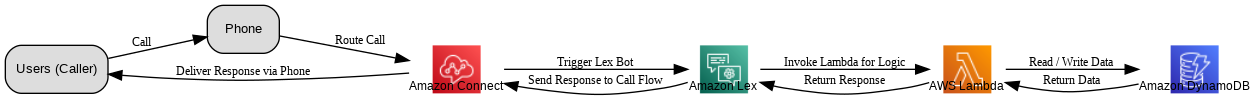

Diagram complete ✅
🗑️ Cleared old icon cache


In [35]:
import json
from graphviz import Digraph
from IPython.display import Image, display
import os
import requests
from cairosvg import svg2png
import shutil



BASE_URL = "https://storage.googleapis.com/eraser-public-assets/canvas-icons/"

# ----------------------------
# Step 1: Load JSON file
# ----------------------------
with open("/content/prompt_0001.json", "r") as f:
    data = json.load(f)

diagram = data.get("messages", [{}])[-1].get("content")
diagram = json.loads(diagram) if diagram else data

# ----------------------------
# Step 2: Alias map for services → Eraser filenames
# ----------------------------
service_alias_map = {
    # Storage
    "s3": "simple-storage-service",

    # Lambda (all flavors)
    "lambda": "lambda",
    "lambda-ingest": "lambda",
    "lambda_query": "lambda",
    "lambda-ingest": "lambda",
    "lambda-query": "lambda",

    # Bedrock (all variants)
    "bedrock": "bedrock",
    "bedrock-ingest": "bedrock",
    "bedrock_query": "bedrock",
    "bedrock-ingest": "bedrock",
    "bedrock-query": "bedrock",

    # API Gateway
    "api-gateway": "api-gateway",
    "api_gateway": "api-gateway",

    # VPC
    "vpc": "vpc",

    # Cognito
    "cognito": "cognito",

    # Amplify
    "amplify": "amplify",

    # SageMaker
    "sagemaker": "sagemaker",

    # OpenSearch
    "opensearch": "opensearch-service",
    "opensearch-service": "opensearch-service",

    # Fargate
    "fargate": "fargate",

    # Generic user / client
    "client": "generic-user",
    "user": "generic-user",
    "users": "generic-user",
    "end-user": "generic-user",
    "customer": "generic-user",

    # Third-party (unsupported, fallback to box)
    "pinecone": None
}

# ----------------------------
# Step 3: Build icon map from JSON + aliases
# ----------------------------
icon_filename_map = {}
for ent in diagram["entities"]:
    service = (ent.get("service") or ent.get("id")).lower().replace("_", "-")
    alias = service_alias_map.get(service, service)

    if alias is None:
        print(f"⚠️ No AWS icon for {service}, will use default box")
        continue

    if alias == "generic-user":
        icon_filename_map[service] = "generic-user.svg"  # provide locally if needed
    else:
        icon_filename_map[service] = f"aws-{alias}.svg"

print("Generated icon_filename_map:")
print(json.dumps(icon_filename_map, indent=2))

# ----------------------------
# Step 4: Download & cache icons
# ----------------------------
def download_and_cache_icon(service, cache_folder=CACHE_FOLDER):
    filename = icon_filename_map.get(service)
    if not filename:
        return None

    url = BASE_URL + filename
    svg_path = os.path.join(cache_folder, filename)
    png_path = svg_path.replace(".svg", ".png")

    if not os.path.exists(png_path):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            with open(svg_path, "wb") as f:
                f.write(response.content)
            # Convert to PNG
            svg2png(url=url, write_to=png_path)
            print(f"Downloaded and converted: {service} → {png_path}")
        except Exception as e:
            print(f"⚠️ Could not fetch icon for {service}: {e}")
            return None
    return png_path

# ----------------------------
# Step 5: Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", bgcolor="white")
dot.attr("node", shape="rect", style="rounded,filled", fontname="Helvetica", fontsize="10", fillcolor="#DDDDDD")

for ent in diagram["entities"]:
    node_id = ent["id"]
    label = ent.get("label", node_id)
    service = (ent.get("service") or node_id).lower().replace("_", "-")

    icon_path = download_and_cache_icon(service)

    if icon_path and os.path.exists(icon_path):
        dot.node(
            node_id,
            label=label,
            image=icon_path,
            shape="none",
            labelloc="b",
            fontsize="9",
            fixedsize="false",
            imagescale="true",
            margin="0",
            style=""
        )
    else:
        print(f"⚠️ No icon for {service}, using default box")
        dot.node(node_id, label=label, shape="rect", style="rounded,filled", fillcolor="#DDDDDD")

# Add edges
for rel in diagram["relationships"]:
    style = rel.get("style", {})
    attrs = {}
    if style.get("lineType") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], label=rel.get("label", ""), fontsize="9", **attrs)

# ----------------------------
# Step 6: Render & display
# ----------------------------
print("\nRendering diagram...")
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))
print("Diagram complete ✅")

# ----------------------------
# Step 0: Clear cache folder
# ----------------------------
CACHE_FOLDER = "icon_cache"
if os.path.exists(CACHE_FOLDER):
    shutil.rmtree(CACHE_FOLDER)
    print("🗑️ Cleared old icon cache")
os.makedirs(CACHE_FOLDER)
